<a href="https://colab.research.google.com/github/CVasquezroque/RP-G1/blob/main/CNN_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta primera Versión de la implementación se siguió en base a la distribución de datos obtenida del trabajo de [Oh. et al, 2018](https://www.sciencedirect.com/science/article/abs/pii/S0010482518301446)

### Descarga de Base de Datos de MIT-BIH y librerías requeridas

In [1]:
!wget -r -N -q -c -np https://physionet.org/files/mitdb/1.0.0/

In [2]:
!pip --q install wfdb

     |████████████████████████████████| 143kB 5.0MB/s 


In [4]:
import pywt
import math
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import glob
import scipy.signal as sg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D,InputLayer,LSTM
from keras.optimizers import  Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

### Preprocesamiento de la señal

In [6]:
listFiles = glob.glob('physionet.org/files/mitdb/1.0.0/*.hea')# os.listdir('Training_WFDB/*.hea')
listFiles[0]

'physionet.org/files/mitdb/1.0.0/115.hea'

Se realizó una alineación de los picos R con la finalidad de homgenizar los segmentos de señales ECG

In [8]:
def align_peaks(filtered_signal,newR,r_peaks,sampling_rate,tol):
  for r_peak in r_peaks:
      r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
      r_right = np.minimum(r_peak + int(tol * sampling_rate), len(filtered_signal))
      newR.append(r_left + np.argmax(filtered_signal[r_left:r_right]))
  r_peaks = np.array(newR, dtype="int")
  return r_peaks

Se realizó una segmentación de la señal, tomando 99 muestras previas al pico R y 160 muestras después del siguiente pico R detectado. Asimismo, previo a la segmentación , la señal fue filtrada con 2 filtros de mediana de 200 ms y 600 ms de ancho de ventana, y normalizada.

Asimismo las anotaciones fueron agrupadas en base a lo determinado por el AAMI, y las clases definidas se basaron en estas anotaciones (enumeradas de 0 a 4). Sin embargo, siguiendo los modelos de estudio, se descartó la categoría de la clase 4. 

In [22]:
def beat_segmentation(paths,fs,invalid_labels,before=99,after=160):
  x,y = [],[]
  for path in paths:
    signal,meta = wfdb.rdsamp(path[:-4],channels=[0])
    ann = wfdb.rdann(path[:-4],'atr')
    r_peaks, labels = ann.sample, np.array(ann.symbol)
    indices = [i for i, label in enumerate(labels) if label not in invalid_labels]
    r_peaks, labels = r_peaks[indices], labels[indices]
    tol = 0.05
    newR = []
    r_peaks = align_peaks(signal,newR,r_peaks,fs,tol)
    temp_sig = signal.flatten()
    baseline = sg.medfilt(sg.medfilt(temp_sig, int(0.2 * fs) - 1), int(0.6 * fs) - 1)
    filtered_signal = temp_sig - baseline
    filtered_signal = filtered_signal.reshape(len(filtered_signal),1)
    normalized_signal = filtered_signal / np.mean(filtered_signal[r_peaks])
    AAMI = {
    "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
    "A": 1, "a": 1, "S": 1, "J": 1,  # SVEB
    "V": 2, "E": 2,  # VEB
    "F": 3,  # F
    "/": 4, "f": 4, "Q": 4  # Q
    }
    categories = [AAMI[label] for label in labels]
    for i in range(len(r_peaks)):
      if i == 0 or i == len(r_peaks) - 1:
        continue
      if categories[i] == 4:  # remove AAMI Q class
        continue     
      
      seg_signal = normalized_signal[r_peaks[i] - before: r_peaks[i+1] + after]
      x.append(seg_signal)
      y.append(categories[i])
  return x,y

In [23]:
invalid_labels = ['|', '~', '!', '+', '[', ']', '"', 'x']
x,y = beat_segmentation(listFiles,360,invalid_labels)

Según lo hallado en la literatura, para poder tener una mayo homongenización de los datos, se optó por tener cada segmento con 1000 muestras, reduciendo el tamaño de la señal para casos de más de 1000 muestras o realizando un zero padding para casos de menos de 1000 muestras

In [28]:
x2 = []
for i in x:
  if i.shape[0]<1000:
    z_pad = i.flatten()
    z_pad = np.pad(z_pad, (0, 1000-len(z_pad)), 'constant')
    z_pad = z_pad.reshape((1000,1))
    x2.append(z_pad)
  else:
    if i.shape[0]>=1000:
      x2.append(i[:1000])
    else:
      print(i.shape)


In [29]:
k_fold = math.floor(len(x2)/10)
k_fold

10136

In [31]:
X_folds = []
y_folds = []
for k in range(10):
  temp = x2[k*k_fold:(k+1)*k_fold]
  temp2 = y[k*k_fold:(k+1)*k_fold]
  X_folds.append(temp)
  y_folds.append(temp2)

Hasta este punto se tiene que X_fold contiene 10 paquetes de 10136 segmentos de tamaño 1000, y_fold tiene 10 paquetes de 10136 valores entre 0 y 3

Solo tomamos uno de estos paquetes debido a que el entrenamiento demora 60 -70 segundos por epoca durante 150 epocas lo que supera la cantidad de tiempo de conexión en Colab

In [33]:
X = X_folds[1]
Y = y_folds[1]

X = np.array(X)
Y = np.array(Y)


In [34]:
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1,1))
enc.categories_
Y = enc.transform(Y.reshape(-1,1))
Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [35]:
np.unique(Y,axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

### Modelo de Entrenamiento

Dividmos el dataset en training, testing y validación

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
x_train.shape, y_train.shape

((9122, 1000, 1), (9122, 4))

In [39]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_val.shape,y_val.shape

((7297, 1000, 1), (7297, 4), (1825, 1000, 1), (1825, 4))

In [40]:
from keras.activations import relu,sigmoid
lr = 0.001


model = Sequential(
      [
      Conv1D(3,20,activation="relu",use_bias=False,input_shape=(1000,1)),
      
      MaxPooling1D(2,strides=2),
      
      Conv1D(6,10,activation="relu",use_bias=False),

      MaxPooling1D(2,strides=2),
      
      Conv1D(6,5,activation="relu",use_bias=False),

      MaxPooling1D(2,strides=2),

      LSTM(20,recurrent_dropout=0.2),

      Dense(20,activation="relu"),

      Dropout(0.2),

      Dense(10,activation="relu"),

      Dropout(0.2),

      Dense(4,activation="softmax")

      ])

model.compile(optimizer=Adam(lr), loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 981, 3)            60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 490, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 481, 6)            180       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 240, 6)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 236, 6)            180       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 118, 6)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                2

In [27]:
log = model.fit(x_train, 
                y_train, 
                batch_size=10, 
                epochs=150, 
                validation_data=(x_val, 
                                 y_val))

Epoch 1/150
730/730 [==============================] - 92s 90ms/step - loss: 0.6305 - accuracy: 0.9048 - val_loss: 0.3502 - val_accuracy: 0.9123
Epoch 2/150
730/730 [==============================] - 66s 91ms/step - loss: 0.3783 - accuracy: 0.9154 - val_loss: 0.3440 - val_accuracy: 0.9123
Epoch 3/150
730/730 [==============================] - 65s 89ms/step - loss: 0.3750 - accuracy: 0.9127 - val_loss: 0.3439 - val_accuracy: 0.9123
Epoch 4/150
730/730 [==============================] - 66s 90ms/step - loss: 0.3749 - accuracy: 0.9090 - val_loss: 0.3109 - val_accuracy: 0.9123
Epoch 5/150
730/730 [==============================] - 65s 90ms/step - loss: 0.3310 - accuracy: 0.9095 - val_loss: 0.2617 - val_accuracy: 0.9112
Epoch 6/150
730/730 [==============================] - 65s 88ms/step - loss: 0.2926 - accuracy: 0.9122 - val_loss: 0.2689 - val_accuracy: 0.9090
Epoch 7/150
730/730 [==============================] - 66s 91ms/step - loss: 0.2758 - accuracy: 0.9182 - val_loss: 0.2367 - val_ac

In [ ]:
np.save('model_log.npy',log.history)

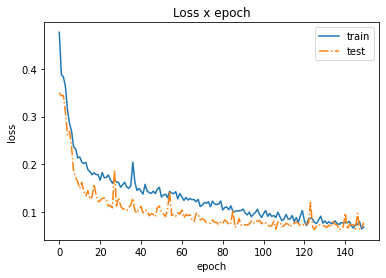

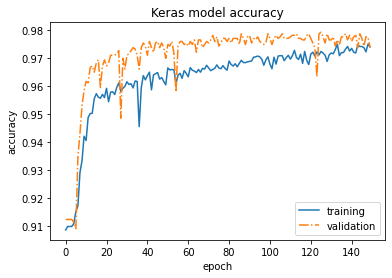

In [75]:
plt.figure()
plt.title("Loss x epoch")
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'],'-.',label='test')
plt.xlabel('epoch');
plt.ylabel('loss')
plt.legend()
plt.savefig('losses.png', dpi=300, bbox_inches='tight')


plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'],'-.')
plt.legend(['training', 'validation'], loc='lower right')

plt.savefig('accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

In [263]:
x_test.shape,y_test.shape

((1014, 1000, 1), (1014, 4))

In [264]:
model.save('model_v1.h5')

In [32]:
from keras import models
new_model = models.load_model('model_v1.h5')

In [44]:
#y_pred = model.predict(x_test)
y_pred_raw = new_model.predict(x_test)

In [321]:
comparison = np.testing.assert_allclose(y_pred, y_pred_loaded, rtol=1e-6, atol=1e-6)
if comparison!=None:
  print("The models are not equal")
else:
  print("The models are equal")

The models are equal


In [45]:
y_pred_raw

array([[9.9873155e-01, 1.2683322e-03, 7.6006614e-08, 1.0585085e-19],
       [9.9827027e-01, 1.7294642e-03, 2.7244016e-07, 2.1985602e-18],
       [9.9830294e-01, 1.6968526e-03, 2.7771958e-07, 2.1201224e-18],
       ...,
       [9.9999845e-01, 1.5291855e-06, 3.7265364e-12, 1.8281229e-36],
       [9.9999857e-01, 1.3934193e-06, 4.1318216e-12, 1.5807332e-36],
       [9.9997127e-01, 2.8728969e-05, 6.5309765e-11, 3.6165361e-30]],
      dtype=float32)

In [46]:
y_pred = np.argmax(y_pred_raw,axis=1)
np.unique(y_pred,return_counts=True)

(array([0, 1, 2]), array([43534,   786,  5341]))

In [47]:
y_true = np.argmax(y_test,axis=1)
np.unique(y_true,return_counts=True)

(array([0, 1, 2, 3]), array([44218,  1836,  3219,   388]))

In [48]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     44218
           1       0.11      0.05      0.06      1836
           2       0.40      0.67      0.51      3219
           3       0.00      0.00      0.00       388

    accuracy                           0.86     49661
   macro avg       0.36      0.41      0.37     49661
weighted avg       0.86      0.86      0.86     49661



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
cm = confusion_matrix(y_true,y_pred)

In [55]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confussion_matrix_modelo_1.png', dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

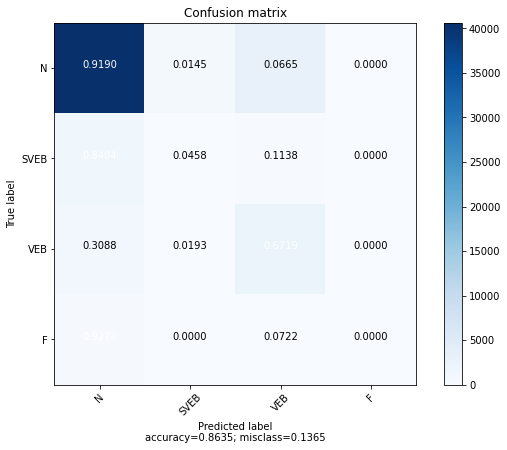

In [56]:
target_names = ["N","SVEB","VEB","F"]
plt.figure()
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)